VAE는 기존 오토인코더와 다르게 n차원의 벡터가 아니라 n차원의 평균과 표준 편차를 만들도록 합니다. 이렇게 되면 n개의 분포가 생기고 n개의 정규 분포에 Z를 샘플링하여 새로운 샘플을 만들어내게 됩니다.

In [20]:
import keras
import tensorflow as tf
from keras import layers, Model
import numpy as np

z 값을 계산하기 위해 Sampling 레이어를 추가합니다.
$$
z = z_{mean} + e^{(0.5 * z_{logvar} \cdot \epsilon)}
$$

Dense layer에 두 $z_{mean}$ $z_{logvar}$ 값을 추가하여 평균과 분산을 학습하도록 합니다. $z_{logbar}$값에 exp를 씌워서 표준 편차를 구하고 $\epsilon$ 을 통해 무작위성을 부여합니다. 

위 수식은 미분가능한(역전파 가능한) 노이즈를 준 Z의 정규분포를 구하는 것과 같습니다.

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch  = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [8]:

encoder_input_layer = layers.Input(shape=x_train.shape[1:], name="input layer")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input_layer)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:]

x = layers.Flatten()(x)

z_mean  = layers.Dense(2, name="z_mean")(x)
z_log_var  = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input_layer, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

I0000 00:00:1729588116.933438   53059 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 18:08:37.039543: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ input layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

손실함수
추가 적으로 VAE는 Kullback-Leibler divergence (KL 발산)을 사용합니다. KL 발산은 한 확률분포가 다른 분포와 얼마나 다른지를 측정합니다. 
```python
kl_loss = -0.5 * sum(1 + z_log_var - z_mean^2 - exp(z_log_var)
```
$$
D_{kl} = [N(\mu, \sigma) || N (0, 1)] = \frac{-1}{2}\sum{(1 + log(\sigma^2) - \mu^2 - \sigma^2)}
$$

이 발산은 모든 차원의 z_mean=0이고 z_log_var = 0 일 때가 최소입니다. 반대로 두 값 모두 0에서 멀어지면 KL값은 증가 합니다.
즉 표준 정규분포의 중앙에서 크게 벗어난 z_mean과 z_log_var를 사용하는 인코더에게 벗어나지 않도록 제약을 가합니다. 
이렇게 표준 정규 분포에 가깝게 되도록 강제하여 잠재공간을 대칭적이고 효과적으로 쓰게 만드는 효과가 있습니다.

$$
KL(q_\theta (z| x_i )|p(z))
$$

In [9]:
decoder_input_layer = layers.Input(shape=(2, ), name="decoder input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input_layer)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_ouput_layer = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output_layer")(x)

decoder = Model(decoder_input_layer, decoder_ouput_layer)

In [11]:
class VAE(Model):
    def __init__ (self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstrution_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_trcker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstrution_loss_tracker, self.kl_loss_trcker]

    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500 * keras.losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum( -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1)
            )
            total_loss =reconstruction_loss + kl_loss

            grads = tape.gradient(total_loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(total_loss)
            self.reconstrution_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_trcker.update_state(kl_loss)

            return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(x_train, epochs=5, batch_size=100)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - kl_loss: 3.8420 - reconstruction_loss: 179.8650 - total_loss: 183.7071
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - kl_loss: 4.9782 - reconstruction_loss: 130.4299 - total_loss: 135.4081
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - kl_loss: 5.0556 - reconstruction_loss: 128.3443 - total_loss: 133.4000
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - kl_loss: 5.1318 - reconstruction_loss: 127.0802 - total_loss: 132.2120
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - kl_loss: 5.1666 - reconstruction_loss: 126.4515 - total_loss: 131.6181


In [22]:
pred = vae.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
3
(10000, 32, 32, 1)


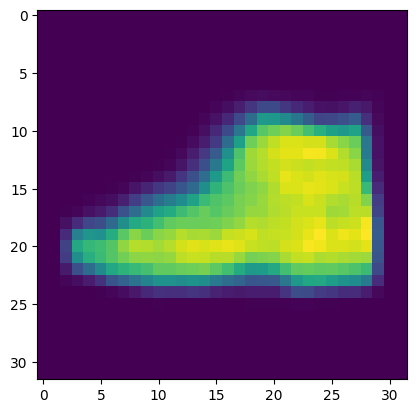

In [32]:
from matplotlib.pylab import plt
plt.imshow(pred[2][0])